In [13]:

# This Python 3 environment comes with many helpful analytics libraries installed
# Here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
#print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced
import xgboost as xgb
from xgboost import XGBClassifier
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import time


Use StandardScaler to process the column data
Train Test Split ratio is 0.3
X_train shape: (199364, 15)
y_train shape: (199364,)
Start Feeding Data
Start Training
Start Predicting

about this model
Accuracy: 0.9996
AUC : 0.981351
F1 Score : 0.859259


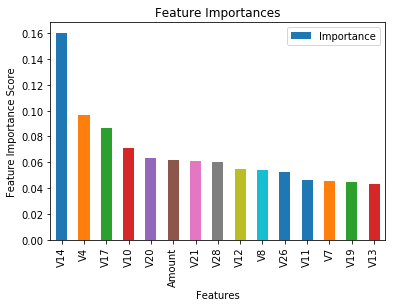

   Features  Importance
0       V14    0.160384
1        V4    0.096822
2       V17    0.086475
3       V10    0.070953
5       V20    0.063562
6    Amount    0.061345
7       V21    0.060606
9       V28    0.059867
4       V12    0.054693
12       V8    0.053954
8       V26    0.052476
10      V11    0.046563
13       V7    0.045085
11      V19    0.044346
14      V13    0.042868
['V14', 'V4', 'V17', 'V10', 'V20', 'Amount', 'V21', 'V28', 'V12', 'V8', 'V26', 'V11', 'V7', 'V19', 'V13']
Total Time is:  1.3744528333346049


In [19]:


"""
(284807, 31)

1. ----
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

2. ----
All columns are float except the 'class' which is 0/1 int

3. ----
No Missing Value

4. ----
print(df['Class'].value_counts())
print(df['Class'].value_counts()[0]/len(df['Class']) * 100)
print(df['Class'].value_counts()[1]/len(df['Class']) * 100)
0    284315
1       492
Name: Class, dtype: int64
99.82725143693798
0.1727485630620034
"""

def data_processor():
    df = pd.read_csv('creditcard.csv')
    df = df.drop('Time', axis=1)
    features_to_select = ['V14', 'V4', 'V17', 'V10', 'V12', 'V20', 'Amount', 'V21', 'V26', 'V28', 'V11', 'V19', 'V8', 'V7', 'V13']

    print('Use StandardScaler to process the column data')
    scaler = StandardScaler()
    df[df.columns[:-1].tolist()] = scaler.fit_transform(df[df.columns[:-1].tolist()])
    # print(df.head(5))
    X = df[df.columns[:-1].tolist()]#select all the factors except target variable, in this case, the target variable is in the lst column
    X = X[features_to_select]# select only interested features
    y = df[df.columns[-1]]

    print("Train Test Split ratio is 0.3")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")

    return X_train, X_test, y_train, y_test

def xgb_classifier(X_train, X_test, y_train, y_test, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    alg = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
                        min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                        objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

    if useTrainCV:
        print("Start Feeding Data")
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train.values, label=y_train.values)
        # xgtest = xgb.DMatrix(X_test.values, label=y_test.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])

    
    print('Start Training')
    alg.fit(X_train, y_train, eval_metric='auc')

    # param_test1 = {'max_depth': [2,4,6],
    #               'n_estimators': [50,100,200]}
    # gsearch1 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
    #                                                 min_child_weight=3, gamma=0.2, subsample=0.8,
    #                                                 colsample_bytree=1.0,
    #                                                 objective='binary:logistic', nthread=4, scale_pos_weight=1,
    #                                                 seed=27),
    #                         param_grid=param_test1,
    #                         scoring='f1',
    #                         n_jobs=4, iid=False, cv=5)
    # gsearch1.fit(X_train, y_train)
    # print(gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_)

    # on test dataset
    print("Start Predicting")
    predictions = alg.predict(X_test)
    pred_proba = alg.predict_proba(X_test)[:, 1]

    # evaluation
    print("\nabout this model")
    print("Accuracy: %.4g" % metrics.accuracy_score(y_test, predictions))
    print("AUC : %f" % metrics.roc_auc_score(y_test, pred_proba))
    print("F1 Score : %f" % metrics.f1_score(y_test, predictions))

    feat_imp = alg.feature_importances_
    feat = X_train.columns.tolist()
    # clf.best_estimator_.booster().get_fscore()
    res_df = pd.DataFrame({'Features': feat, 'Importance': feat_imp}).sort_values(by='Importance', ascending=False)
    res_df.plot('Features', 'Importance', kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.show()
    print(res_df)
    print(res_df["Features"].tolist())
#import eli5
#from eli5.sklearn import PermutationImportance

#perm = PermutationImportance(alg, random_state=1).fit(X_test, y_test)
#eli5.show_weights(perm, feature_names = X_test.columns.tolist())

def logistic_regression():
    """
    F1 score is: 0.7285714285714285
    AUC Score is: 0.9667565771367231
    """
    X_train, X_test, y_train, y_test = data_processor()
    clf = LogisticRegression(C=1e5)
    clf.fit(X_train, y_train)

    print("Score: ", clf.score(X_test, y_test))
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    print("F1 score is: {}".format(f1_score(y_test, y_pred)))
    print("AUC Score is: {}".format(roc_auc_score(y_test, y_pred_proba)))
    
    print(classification_report(y_test,y_pred))
   


def logistic_with_smote():
    """
SMOTE Pipeline Score 0.9770490268366046
SMOTE AUC score:  0.9797647041371416
SMOTE F1 Score:  0.11944319712617871
"""
    X_train, X_test, y_train, y_test = data_processor()

    clf = LogisticRegression(C=1e5)
    clf.fit(X_train, y_train)
    # build model with SMOTE imblearn
    smote_pipeline = make_pipeline_imb(SMOTE(random_state=4), clf)

    smote_model = smote_pipeline.fit(X_train, y_train)
    smote_prediction = smote_model.predict(X_test)
    smote_prediction_proba = smote_model.predict_proba(X_test)[:, 1]

    print(classification_report_imbalanced(y_test, smote_prediction))
    print('SMOTE Pipeline Score {}'.format(smote_pipeline.score(X_test, y_test)))
    print("SMOTE AUC score: ", roc_auc_score(y_test, smote_prediction_proba))
    print("SMOTE F1 Score: ", f1_score(y_test, smote_prediction))


def randomForest():
    """
    F1 score is: 0.7857142857142857
    AUC Score is: 0.9450972761670293
    """
    X_train, X_test, y_train, y_test = data_processor()
    # parameters = {'n_estimators': [10, 20, 30, 50], 'max_depth': [2, 3, 4]}

    clf = RandomForestClassifier(max_depth=4, n_estimators=20)
    # clf = GridSearchCV(alg, parameters, n_jobs=4)
    clf.fit(X_train, y_train)
    print("Score: ", clf.score(X_test, y_test))
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]

    print("F1 score is: {}".format(f1_score(y_test, y_pred)))
    print("AUC Score is: {}".format(roc_auc_score(y_test, y_pred_proba)))

    # print("The Features Importance are: ")  # for feature, value in zip(X_train.columns, clf.feature_importances_):
    #     print(feature, value)
    # print(clf.best_estimator_)
    # print(clf.best_params_)
    # print(clf.best_score_)


def neural_nets():
    """
    Score:  0.9994148145547324
    F1 score is: 0.822695035460993
    AUC Score is: 0.9608730286337007
    """
    X_train, X_test, y_train, y_test = data_processor()
    clf = MLPClassifier(hidden_layer_sizes=(100, 100, 100,))

    clf.fit(X_train, y_train)
    print("Score: ", clf.score(X_test, y_test))
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    print("F1 score is: {}".format(f1_score(y_test, y_pred)))
    print("AUC Score is: {}".format(roc_auc_score(y_test, y_pred_proba)))


if __name__ == "__main__":
    # logistic_regression()
    # randomForest()
    #logistic_with_smote()
    # neural_nets()
    start = time.time()
    X_train, X_test, y_train, y_test = data_processor()
    xgb_classifier(X_train, X_test, y_train, y_test)
    
    print("Total Time is: ", (time.time() - start)/60)







